In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

In [52]:
captions=pd.read_csv('captions.csv')

In [53]:
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [54]:
captions['caption'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 40455 entries, 0 to 40454
Series name: caption
Non-Null Count  Dtype 
--------------  ----- 
40455 non-null  object
dtypes: object(1)
memory usage: 316.2+ KB


In [55]:
captions['caption'].describe()

count                              40455
unique                             40201
top       Two dogs playing in the snow .
freq                                   7
Name: caption, dtype: object

In [320]:
sequences=captions['caption'].tolist()

In [321]:
sequences[:5]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [322]:
for i in range(len(sequences)):
    sequences[i]="start "+sequences[i]

In [323]:
sequences[:5]

['start A child in a pink dress is climbing up a set of stairs in an entry way .',
 'start A girl going into a wooden building .',
 'start A little girl climbing into a wooden playhouse .',
 'start A little girl climbing the stairs to her playhouse .',
 'start A little girl in a pink dress going into a wooden cabin .']

In [324]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(sequences)

In [325]:
import pickle

In [326]:
import pickle
with open('tokenizer_data.pkl','wb') as f:
    pickle.dump({'tokenizer':tokenizer},f)

In [327]:
tokenizer.word_index.items()

dict_items([('a', 1), ('start', 2), ('in', 3), ('the', 4), ('on', 5), ('is', 6), ('and', 7), ('dog', 8), ('with', 9), ('man', 10), ('of', 11), ('two', 12), ('white', 13), ('black', 14), ('boy', 15), ('are', 16), ('woman', 17), ('girl', 18), ('to', 19), ('wearing', 20), ('at', 21), ('people', 22), ('water', 23), ('red', 24), ('young', 25), ('brown', 26), ('an', 27), ('his', 28), ('blue', 29), ('dogs', 30), ('running', 31), ('through', 32), ('playing', 33), ('while', 34), ('shirt', 35), ('down', 36), ('standing', 37), ('ball', 38), ('little', 39), ('grass', 40), ('snow', 41), ('child', 42), ('person', 43), ('jumping', 44), ('over', 45), ('three', 46), ('front', 47), ('sitting', 48), ('holding', 49), ('up', 50), ('field', 51), ('small', 52), ('by', 53), ('large', 54), ('green', 55), ('one', 56), ('group', 57), ('yellow', 58), ('her', 59), ('walking', 60), ('children', 61), ('men', 62), ('into', 63), ('air', 64), ('beach', 65), ('near', 66), ('mouth', 67), ('jumps', 68), ('another', 69), (

In [330]:
max_length=max(len(s.split(" ")) for s in sequences)

In [331]:
max_length

39

In [332]:
def tokenize(sequence):
    sequence=tokenizer.texts_to_sequences(sequence)[0]

    input_sequence=[]
    for j in range(1,len(sequence)):
        n_gram_sequence=sequence[:j+1]
        input_sequence.append(n_gram_sequence)

    input_sequences=np.array(pad_sequences(input_sequence,maxlen=39,padding='pre'))

    xs = input_sequences[:,:-1]
    labels = input_sequences[:,-1]

    return xs,labels


In [388]:
def getdata(data):
    xs,labels=tokenize(data)
    xs=np.array(xs)
    labels=np.array(labels)
    img=captions[captions['caption']==data[0][6:]]['image']
    img=cv2.imread('Images/'+img.iloc[0])
    img=cv2.resize(img,(224,224))
    img=img/255.0
    images=[img]*len(xs)
    return xs,labels,images

In [349]:
def create_dataset(n):
    xs=[]
    labels=[]
    images=[]
    for i in sequences[n:n+1]:
        x,label,image=getdata([i])
        xs.extend(x)
        labels.extend(label)
        images.extend(image)

    xs=np.array(xs)
    labels=np.array(labels)
    images=np.array(images)

    labels = tf.keras.utils.to_categorical(labels, num_classes=8493)
    
        
    return xs,images,labels

In [350]:
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,Conv2D,MaxPooling2D,Flatten,Dropout,concatenate,add,Reshape

In [351]:
max_length=39

In [352]:
input1 = Input(shape=(224,224,3))
input2 = Input(shape=(max_length,))

x1 = Conv2D(32,(3,3),activation='relu')(input1)
x1 = MaxPooling2D((2,2))(x1)
x1 = Conv2D(16,(3,3),activation='relu')(x1)
x1 = MaxPooling2D((2,2))(x1)

x1 = Flatten()(x1)
x1 = Dense(128,activation='relu')(x1)
x1 = Dropout(0.5)(x1)

x3=Reshape((1,128))(x1)
x2 = Embedding(8493,128,input_length=max_length)(input2)
x3=concatenate([x3,x2],axis=1)
x2=LSTM(128,return_sequences=False)(x3)
x2 = Dense(128,activation='relu')(x2)

x = add([x1,x2])
x = Dense(128,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8493,activation='softmax')(x)


2023-09-04 17:48:20.584590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-04 17:48:20.585990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-04 17:48:20.587374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [353]:
model=tf.keras.Model(inputs=[input2,input1],outputs=x)

In [354]:
# model=tf.keras.models.load_model('model.h5')

In [355]:
from tensorflow.keras.utils import plot_model

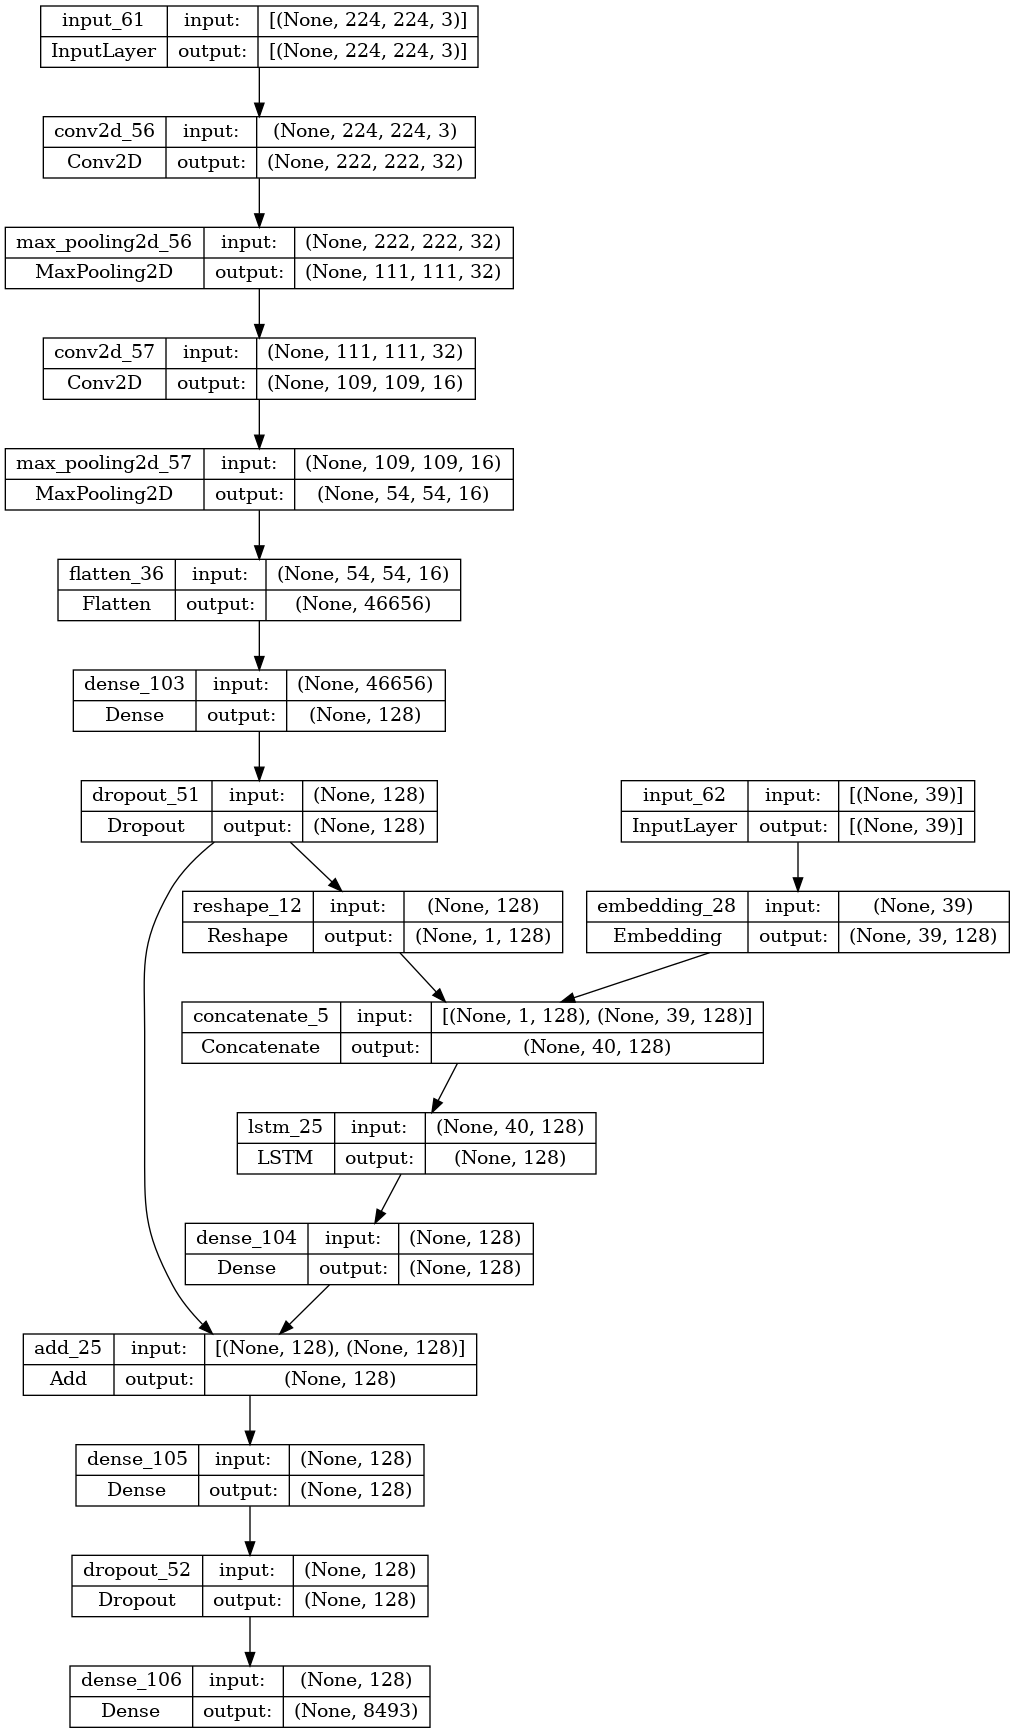

In [356]:
plot_model(model,show_shapes=True)

In [357]:
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 222, 222, 32  896         ['input_61[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_56 (MaxPooling2D  (None, 111, 111, 32  0          ['conv2d_56[0][0]']              
 )                              )                                                          

In [358]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])

In [359]:
n=[x for x in range(0,8000,1)]
print(len(n))

8000


In [360]:
class datagenerator(tf.keras.utils.Sequence):
    def __init__(self):
        self.n=0
        self.base=0

    def on_epoch_end(self):
        self.base=self.base

    def __getitem__(self,index):
        self.n=self.base+index
        X1,X2,Y=create_dataset(self.n)
        Y=tf.expand_dims(Y,axis=-1)      
        return [X1,X2],Y

    def __len__(self):
        return 200

In [361]:
datagen=datagenerator()

In [389]:
a,b=data=datagen.__getitem__(0)

In [299]:
b.shape

TensorShape([71, 51, 1])

In [391]:
model.fit(datagen,epochs=100,shuffle=False)

Epoch 1/100


2023-09-04 18:01:32.970966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


200/200 [==============================] - 4s 20ms/step - loss: 4.0649 - accuracy: 0.1969
Epoch 2/100
200/200 [==============================] - 4s 19ms/step - loss: 3.9254 - accuracy: 0.2135
Epoch 3/100
200/200 [==============================] - 4s 19ms/step - loss: 3.8347 - accuracy: 0.2262
Epoch 4/100
200/200 [==============================] - 4s 19ms/step - loss: 3.7058 - accuracy: 0.2345
Epoch 5/100
200/200 [==============================] - 4s 20ms/step - loss: 3.5508 - accuracy: 0.2594
Epoch 6/100
200/200 [==============================] - 4s 20ms/step - loss: 3.4510 - accuracy: 0.2677
Epoch 7/100
200/200 [==============================] - 4s 19ms/step - loss: 3.4012 - accuracy: 0.2830
Epoch 8/100
200/200 [==============================] - 4s 19ms/step - loss: 3.3294 - accuracy: 0.2773
Epoch 9/100
200/200 [==============================] - 4s 19ms/step - loss: 3.2443 - accuracy: 0.2948
Epoch 10/100
200/200 [==============================] - 4s 19ms/step - loss: 3.1523 - accuracy

In [397]:
def predict(image,tokenizer,model):
    img=cv2.imread(image)
    plt.imshow(img)
    img=cv2.resize(img,(224,224))
    img=img/255.0
    img=np.array([img])
    img.shape
    in_text='start'
    for i in range(38):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],maxlen=39,padding='pre')
        sequence=np.array(sequence)
        y=model.predict([sequence,img])
        print(y)
        y=np.argmax(y)
        word=''
        for word,index in tokenizer.word_index.items():
            if index==y:
                word=word
                break
        in_text+=' '+word
        if word=='endseq':
            break
    return in_text

1/1 [==============================] - 0s 20ms/step
[[1.2461708e-12 3.8949037e-01 1.6461069e-12 ... 1.5659877e-12
  2.3328566e-12 1.8902896e-12]]
1/1 [==============================] - 0s 24ms/step
[[2.6395149e-35 6.0889341e-17 1.5028670e-34 ... 3.6354075e-34
  3.5240414e-34 1.2297903e-34]]
1/1 [==============================] - 0s 23ms/step
[[1.3701006e-22 5.6602168e-13 4.1680338e-22 ... 5.9913544e-22
  8.2909276e-22 1.8248009e-22]]
1/1 [==============================] - 0s 25ms/step
[[8.8150101e-34 5.9066412e-18 3.0383449e-33 ... 4.3871999e-33
  1.0781981e-32 1.1297130e-33]]
1/1 [==============================] - 0s 22ms/step
[[6.5711427e-33 9.9904948e-01 5.4913413e-32 ... 1.6020510e-32
  5.0635706e-32 8.1272893e-33]]
1/1 [==============================] - 0s 22ms/step
[[5.2164522e-21 7.3164479e-08 4.3694653e-20 ... 1.3864741e-20
  3.5419716e-20 5.1422442e-21]]
1/1 [==============================] - 0s 20ms/step
[[1.8151224e-24 7.6914377e-16 1.9489708e-23 ... 1.4978604e-23
  1.417658

'start white dog playing with a red ball on the shore near the water and the white dog is running through the water in the water and the white dog is white dog with near of white dog is'

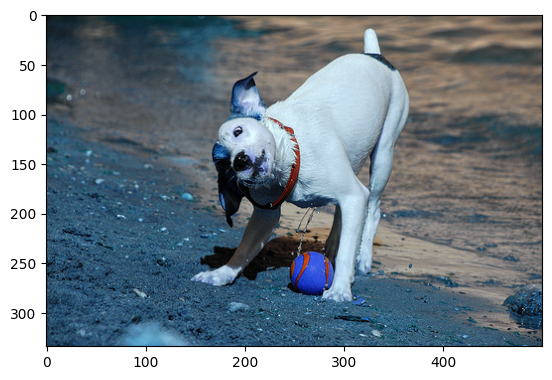

In [399]:
predict('./Images/1012212859_01547e3f17.jpg',tokenizer,model)

In [54]:
model.save('model.h5')